#Выгрузка данных

In [ ]:
import pandas as pd
import re
import numpy as np
import math

In [ ]:
parameters = pd.read_csv('apics_data/parameters.csv')
parameters = parameters[['ID', 'Name', 'Type']]

In [ ]:
values_full = pd.read_csv('apics_data/values-full.csv')
values_full = values_full[['ID', 'Language_ID', 'Parameter_ID', 'Value', 'Code_ID', 'Frequency', 'Confidence']]

In [ ]:
domainelement = pd.read_csv('apics_data/domainelement.csv')

In [ ]:
Parameter_name = []
Parameter_value_name = []
Parameter_type = []
for i, code in enumerate(values_full['Code_ID']):
    current_parameter = parameters[parameters['ID']==values_full['Parameter_ID'][i]]
    Parameter_name.append(current_parameter['Name'].values[0])
    Parameter_type.append(current_parameter['Type'].values[0])
    current_domainelement = domainelement[domainelement['id']==code]
    Parameter_value_name.append(current_domainelement['name'].values[0])

In [ ]:
values_full['Parameter_name'] = Parameter_name
values_full['Parameter_value_name'] = Parameter_value_name
values_full['Parameter_type'] = Parameter_type

In [ ]:

#убираем диалектв и оставляем только основные языки
only_primary_langs = values_full[values_full['Language_ID']<1000]

Param_by_lang = only_primary_langs.pivot_table('Frequency', index='Code_ID', columns='Language_ID').T

In [ ]:

only_primary_langs2 = only_primary_langs[(only_primary_langs['Parameter_type']=='sociolinguistic') | (only_primary_langs['Parameter_type']=='primary')]
#only_primary_langs2 = only_primary_langs2[only_primary_langs2['Parameter_type']=='primary']

In [ ]:
Param_by_lang2 = only_primary_langs2.pivot_table('Frequency', index='Code_ID', columns='Language_ID').T

In [ ]:
Param_by_lang2 = Param_by_lang2.fillna(0)

In [ ]:
lex_lang = only_primary_langs[only_primary_langs['Parameter_ID']==308]
lex_lang

lex_lang_lang = lex_lang.pivot_table('Frequency', index='Code_ID', columns='Language_ID').T

lex_lang_lang = lex_lang_lang.fillna(0)
lex_lang_lang.head()

In [ ]:
other_sl_features = only_primary_langs[only_primary_langs['Parameter_ID'].isin(range(309, 315))]

other_sl_features_by_lang = other_sl_features.pivot_table('Frequency', index='Code_ID', columns='Language_ID').T

other_sl_features_by_lang = other_sl_features_by_lang.fillna(0)
other_sl_features_by_lang.head()

#Общая табличка

In [ ]:
Cysouw_creole_features = {
    4: [1, 'Prepositions'],
    1: [1, 'Subject-verb-object (SVO)'],
    12: [0, 'Interrogative phrase not initial'],
    3: [0, 'Modifying adjective follows noun'],
    2: [0, 'Possessum-possessor'],
    62: [1, 'Obligatory pronoun words'],
    23: [0, 'Plural prefix', 'Plural suffix'],
    100: [0, 'Negative affix'],
    70: [1, 'Identity'],
    71: [1, 'Identity'],
    29: [1, 'Indefinite article identical to numeral ‘one’'],
    21: [1, 'Generic-noun-based indefinites'],
    77: [1, 'Transitive']
}

In [ ]:
def make_structural_features_by_lang_table(feature_number, only_primary_langs=only_primary_langs):
    features = only_primary_langs[only_primary_langs['Parameter_ID'].isin([feature_number])]
    features_by_lang_table = features.pivot_table('Frequency', index='Code_ID', columns='Language_ID').T
    features_by_lang_table = features_by_lang_table.fillna(0)
    #добавляем пустые строки для пропущенных языков
    add_indices = pd.Index(range(77)[1:]).difference(features_by_lang_table.index)
    add_df = pd.DataFrame(index=add_indices, columns=features_by_lang_table.columns)
    features_by_lang_table = pd.concat([features_by_lang_table, add_df])
    features_by_lang_table = features_by_lang_table.sort_index()
    features_columns = []
    for col in features_by_lang_table.columns:
        features_columns.append(list(only_primary_langs[only_primary_langs['Code_ID']==col]['Parameter_value_name'].head(1))[0])
    features_by_lang_table.columns = features_columns
    return features_by_lang_table

In [ ]:
#all_languages_Cysouw_creole_features_table.to_excel('all_Cysouw_features.xlsx')

In [ ]:
def make_creole_non_creole_value_table(feature_number, Cysouw_creole_features=Cysouw_creole_features, only_primary_langs=only_primary_langs):
    features_by_lang_table = make_structural_features_by_lang_table(feature_number)
    if Cysouw_creole_features[feature_number][0] == 1 and len(Cysouw_creole_features[feature_number])==2:
        creole_value = Cysouw_creole_features[feature_number][1]
        creole_non_creole_value_table = features_by_lang_table[[creole_value]]
        creole_values = []
        for i in creole_non_creole_value_table[creole_value]:
            if pd.isna(i):
                creole_values.append(i)
            else:
                creole_values.append(int(i>=70))
        creole_non_creole_value_table[creole_value] = creole_values

        feature_name = list(only_primary_langs[only_primary_langs['Parameter_ID']==feature_number]['Parameter_name'].head(1))[0]
        creole_non_creole_value_table = creole_non_creole_value_table[[creole_value]]
        creole_non_creole_value_table.columns = [feature_name + ': ' + creole_value]
        return creole_non_creole_value_table

    if Cysouw_creole_features[feature_number][0] == 0 and len(Cysouw_creole_features[feature_number])==2:
        non_creole_value = Cysouw_creole_features[feature_number][1]
        creole_non_creole_value_table = features_by_lang_table[[non_creole_value]]
        non_creole_values = []
        for i in creole_non_creole_value_table[non_creole_value]:
            if pd.isna(i):
                non_creole_values.append(i)
            else:
                non_creole_values.append(int(1 - int(i>=70)))
        creole_non_creole_value_table['not ' + non_creole_value] = non_creole_values
        feature_name = list(only_primary_langs[only_primary_langs['Parameter_ID']==feature_number]['Parameter_name'].head(1))[0]
        creole_non_creole_value_table = creole_non_creole_value_table[['not ' + non_creole_value]]
        creole_non_creole_value_table.columns = [feature_name + ': ' + 'not ' + non_creole_value]
        return creole_non_creole_value_table

    if Cysouw_creole_features[feature_number][0] == 0 and len(Cysouw_creole_features[feature_number])==3:
        creole_value1 = Cysouw_creole_features[feature_number][1]
        creole_value2 = Cysouw_creole_features[feature_number][2]
        creole_non_creole_value_table1 = features_by_lang_table[[creole_value1]]
        non_creole_values1 = []
        for i in creole_non_creole_value_table1[creole_value1]:
            if pd.isna(i):
                non_creole_values1.append(i)
            else:
                non_creole_values1.append(int(1 - int(i>=70)))
        creole_non_creole_value_table2 = features_by_lang_table[[creole_value2]]
        non_creole_values2 = []
        for i in creole_non_creole_value_table2[creole_value2]:
            if pd.isna(i):
                non_creole_values2.append(i)
            else:
                non_creole_values2.append(int(1 - int(i>=70)))
        creole_non_creole_value_table2[creole_value2] = non_creole_values2
        total_creole_non_creole_value = []
        for i in range(77)[1:]:
            total_creole_non_creole_value.append(int(creole_non_creole_value_table2[creole_value2][i] or 
                                                 creole_non_creole_value_table1[creole_value1][i]))
        feature_name = list(only_primary_langs[only_primary_langs['Parameter_ID']==feature_number]['Parameter_name'].head(1))[0]
        creole_non_creole_value_table1['not ' + creole_value1 + ' or ' + creole_value2] = total_creole_non_creole_value    
        creole_non_creole_value_table = creole_non_creole_value_table1[['not ' + creole_value1 + ' or ' + creole_value2]]
        creole_non_creole_value_table.columns = [feature_name + ': ' + 'not ' + creole_value1 + ' or ' + creole_value2]

        return creole_non_creole_value_table


In [ ]:
def make_socioling_features_by_lang_table(feature_number, only_primary_langs=only_primary_langs, reversed=False):
    socioling_features = only_primary_langs[only_primary_langs['Parameter_ID'].isin([feature_number])]
    socioling_features_by_lang = socioling_features.pivot_table('Frequency', index='Code_ID', columns='Language_ID').T
    socioling_features_by_lang = socioling_features_by_lang.fillna(0)
    #добавляем пустые строки для пропущенных языков
    add_indices = pd.Index(range(77)[1:]).difference(socioling_features_by_lang.index)
    add_df = pd.DataFrame(index=add_indices, columns=socioling_features_by_lang.columns)
    socioling_features_by_lang = pd.concat([socioling_features_by_lang, add_df])
    socioling_features_by_lang = socioling_features_by_lang.sort_index()

    socioling_feature_name = list(socioling_features['Parameter_name'])[0]
    socioling_features_by_lang[socioling_feature_name] = ''
    socioling_features_by_lang['rank for ' + socioling_feature_name] = ''
    for col in socioling_features_by_lang.columns[0:-1]:
        for i, f in enumerate(socioling_features_by_lang[col]):
            if f==100:
                socioling_features_by_lang[socioling_feature_name][i+1] = list(only_primary_langs[only_primary_langs['Code_ID'].isin([col])].head(1)['Parameter_value_name'])[0]
                socioling_features_by_lang['rank for ' + socioling_feature_name][i+1] = int(col[-1:]) - 1
    if reversed:
        for i, r in enumerate(socioling_features_by_lang['rank for ' + socioling_feature_name]):
            if r == '':
                socioling_features_by_lang['rank for ' + socioling_feature_name][i+1] = np.nan
        max_rank = socioling_features_by_lang['rank for ' + socioling_feature_name].max()
        socioling_features_by_lang['reversed rank for ' + socioling_feature_name] = [abs(r-max_rank) for r in socioling_features_by_lang['rank for ' + socioling_feature_name]]
        socioling_features_by_lang['rank for ' + socioling_feature_name] = socioling_features_by_lang['reversed rank for ' + socioling_feature_name]
        #return socioling_features_by_lang[[socioling_feature_name, 'rank for ' + socioling_feature_name, 'reversed rank for ' + socioling_feature_name]]
    return socioling_features_by_lang[[socioling_feature_name, 'rank for ' + socioling_feature_name]]

In [ ]:
feature_strings = ['Domains of use', 'Geographic variation', 'Urban/rural variation', 'Social variation']
def make_socioling_features_by_lang_table_for_variation_and_domains(feature_str, only_primary_langs=only_primary_langs, reversed=False):
    socioling_features = only_primary_langs[only_primary_langs['Parameter_name'].str.contains(feature_str)]
    socioling_features_by_lang = socioling_features.pivot_table('Value', index='Code_ID', columns='Language_ID').T
    socioling_features_by_lang = socioling_features_by_lang.fillna(0)
    #добавляем пустые строки для пропущенных языков
    add_indices = pd.Index(range(77)[1:]).difference(socioling_features_by_lang.index)
    add_df = pd.DataFrame(index=add_indices, columns=socioling_features_by_lang.columns)
    socioling_features_by_lang = pd.concat([socioling_features_by_lang, add_df])
    socioling_features_by_lang = socioling_features_by_lang.sort_index()
    value_to_grade = {1.0:1, 2.0:0.5, 3.0:0, 4.0:0}
    socioling_features_by_lang = socioling_features_by_lang.replace(value_to_grade)
    socioling_features_by_lang[feature_str] = socioling_features_by_lang.sum(axis=1)
    socioling_features_by_lang[feature_str] = socioling_features_by_lang[feature_str].astype('int64')

    return socioling_features_by_lang[[feature_str]]

In [ ]:
#создаём общую табличку для признаков из Cysouw
sl_features = [308, 309, 310, 311, 312, 313, 314, 326]
feature_strings_for_domains_and_variation = ['Domains of use', 'Geographic variation', 'Urban/rural variation', 'Social variation']
all_languages_Cysouw_creole_features_table=pd.DataFrame()

for f in list(Cysouw_creole_features.keys()):
    new_df = make_creole_non_creole_value_table(f)
    new_df = new_df.replace(0, '-creole')
    new_df = new_df.replace(1, '+creole')
    all_languages_Cysouw_creole_features_table = pd.concat([all_languages_Cysouw_creole_features_table, new_df], axis=1)
for f in sl_features:
    if f in [309, 310, 311]:
        new_df = make_socioling_features_by_lang_table(f, reversed=True)
    else:
        new_df = make_socioling_features_by_lang_table(f)
    all_languages_Cysouw_creole_features_table = pd.concat([all_languages_Cysouw_creole_features_table, new_df], axis=1)
for f in feature_strings_for_domains_and_variation:
    new_df = make_socioling_features_by_lang_table_for_variation_and_domains(f)
    all_languages_Cysouw_creole_features_table = pd.concat([all_languages_Cysouw_creole_features_table, new_df], axis=1)

In [ ]:
all_languages_Cysouw_creole_features_table=pd.DataFrame()
for f in sl_features:
    if f in [309, 310, 311]:
        new_df = make_socioling_features_by_lang_table(f, reversed=True)
    else:
        new_df = make_socioling_features_by_lang_table(f)
    all_languages_Cysouw_creole_features_table = pd.concat([all_languages_Cysouw_creole_features_table, new_df], axis=1)
for f in feature_strings_for_domains_and_variation:
    new_df = make_socioling_features_by_lang_table_for_variation_and_domains(f)
    all_languages_Cysouw_creole_features_table = pd.concat([all_languages_Cysouw_creole_features_table, new_df], axis=1)

In [ ]:
#all_languages_Cysouw_creole_features_table.to_excel('comlexity_features.xlsx')

# Таблицы сопряженности и тест фишера

In [ ]:
def make_contingency_table(st_feature, sl_feature, languages_table=all_languages_Cysouw_creole_features_table, 
                           feature_strings_for_domains_and_variation=feature_strings_for_domains_and_variation):
    temp_table = languages_table[[st_feature, sl_feature]]
    #удаляем строки, где нет данных по одному из признаков
    temp_table = temp_table.replace('', np.nan)
    temp_table = temp_table.dropna()
    contingency_table = pd.concat([temp_table.groupby(sl_feature).sum(), temp_table.groupby(sl_feature).count()], axis=1)
    contingency_table.columns = [st_feature, 'not ' + st_feature]
    contingency_table['not ' + st_feature] = contingency_table['not ' + st_feature] - contingency_table[st_feature]
    contingency_table_plus = contingency_table.copy()
    contingency_table_plus['Proportion of ' + st_feature] = contingency_table[st_feature] / (contingency_table[st_feature] + contingency_table['not ' + st_feature])
    if sl_feature not in feature_strings_for_domains_and_variation:
        ranks = [list(languages_table[languages_table[sl_feature]==i]['rank for ' + sl_feature])[0] for i in contingency_table.index]
        contingency_table_plus['ranks'] = ranks
    else:
        contingency_table_plus['ranks'] = contingency_table_plus.index
    return contingency_table, contingency_table_plus.sort_values('ranks')

In [ ]:
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()
stats = importr('stats')

p_values = {}
sl_features_names = ['Lexifier language', 'Proportion of native speakers', 'Ongoing creolization of pidgins', 
                     'Increasing use', 'Language abandonment', 'Size of speaker community', 'Gender-related use', 'Contact with other languages',
                     'Domains of use', 'Geographic variation', 'Urban/rural variation', 'Social variation']
final_stat_for_Cysouw_features = pd.DataFrame(index=all_languages_Cysouw_creole_features_table.columns[:13], columns=sl_features_names)
final_stat_for_Cysouw_features_graphs = pd.DataFrame(index=all_languages_Cysouw_creole_features_table.columns[:13], columns=sl_features_names)

for f in sl_features_names:
    p_values[f] = []

for sl_feature in sl_features_names:
    #print('\n\n')
    #print(sl_feature)
    #print('\n')
    for st_feature in all_languages_Cysouw_creole_features_table.columns[:13]:
        contingency_table, contingency_table_plus = make_contingency_table(st_feature, sl_feature)
        m = np.array(contingency_table)
        res = stats.fisher_test(m)
        #print('{} vs {} p-value: {}'.format(st_feature, sl_feature, res[0][0]))            
        p_values[sl_feature].append(res[0][0])
        if res[0][0] < 0.05:
            final_stat_for_Cysouw_features[sl_feature][st_feature] = round(res[0][0], 3)
            final_stat_for_Cysouw_features_graphs[sl_feature][st_feature] = contingency_table_plus[contingency_table_plus.columns[-2:]]
        else:
            final_stat_for_Cysouw_features[sl_feature][st_feature] = '--'
        #except:
            #print(f'smth went wrong for {st_feature} and {sl_feature}')
    num_of_signf_p = 0
    for p in p_values[sl_feature]:
        if p<0.05:
            num_of_signf_p+=1
    #print(num_of_signf_p)

In [ ]:
lexifiers = ['English', 'Dutch', 'Portuguese', 'Spanish', 'French', 'Bantu',
       'Other', 'Arabic', 'Malay']
sl_features_names2 = ['Proportion of native speakers', 'Ongoing creolization of pidgins', 
                     'Increasing use', 'Language abandonment', 'Size of speaker community', 'Gender-related use', 'Contact with other languages',
                     'Domains of use', 'Geographic variation', 'Urban/rural variation', 'Social variation']
all_final_stat_for_Cysouw_features_by_lex = {}
for lex in lexifiers:
    final_stat_for_Cysouw_features_by_lex = pd.DataFrame(index=all_languages_Cysouw_creole_features_table.columns[:13], columns=sl_features_names2)
    final_stat_for_Cysouw_features_by_lex_graphs = pd.DataFrame(index=all_languages_Cysouw_creole_features_table.columns[:13], columns=sl_features_names2)
    df_lexifier = all_languages_Cysouw_creole_features_table[all_languages_Cysouw_creole_features_table['Lexifier language']==lex]
    for sl_feature in sl_features_names2:
        for st_feature in all_languages_Cysouw_creole_features_table.columns[:13]:
            contingency_table, contingency_table_plus = make_contingency_table(st_feature, sl_feature, df_lexifier)
            m = np.array(contingency_table)
            if len(m) < 2:
                final_stat_for_Cysouw_features_by_lex[sl_feature][st_feature] = 'no'
                continue
            else:
                res = stats.fisher_test(m)
            if res[0][0] < 0.05:
                final_stat_for_Cysouw_features_by_lex[sl_feature][st_feature] = round(res[0][0], 3)
                final_stat_for_Cysouw_features_by_lex_graphs[sl_feature][st_feature] = contingency_table_plus[contingency_table_plus.columns[-2:]]
            else:
                final_stat_for_Cysouw_features_by_lex[sl_feature][st_feature] = '--'
        all_final_stat_for_Cysouw_features_by_lex[lex] = final_stat_for_Cysouw_features_by_lex

In [ ]:
a = all_languages_Cysouw_creole_features_table[['Lexifier language', 'Size of speaker community']]
b = pd.crosstab(a['Lexifier language'], a['Size of speaker community'])

In [ ]:
for c in b.columns:
    b[c] = b[c] / b[c].sum()
b.columns = ['Less than\n 100 speakers\nor extinct',
 'Less than\n 1,000 speakers',
 'Less than\n 10,000 speakers',
 'Less than\n 100,000 speakers',
 'Less than\n 1,000,000 speakers',
 'More than\n 1,000,000 speakers']

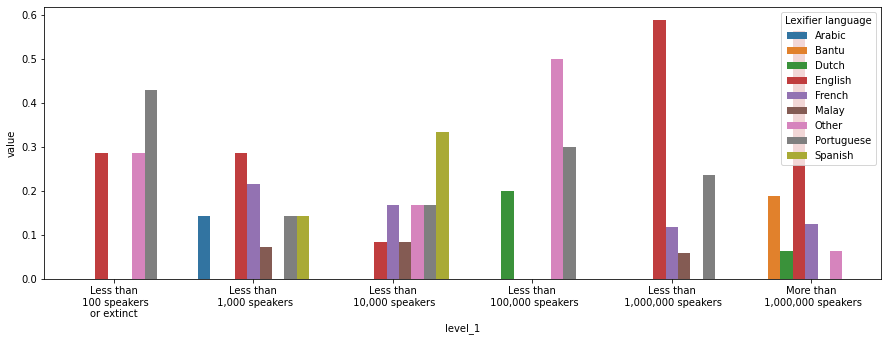

In [ ]:
#sns.barplot(data=b, x='Size of speaker community', hue='Lexifier language')
#b.plot.bar(stacked=True)
fig = plt.figure(figsize=(15, 5))
stacked = b.stack().reset_index().rename(columns={0:'value'})
stacked

 # plot grouped bar chart
sns.barplot(x=stacked['level_1'] , y=stacked['value'], hue=stacked['Lexifier language'])

In [ ]:
#final_stat_for_Cysouw_features.to_excel('final_stat_for_Cysouw_features.xlsx')

#Итог: значимые взаимосвязи графики для пар признаков со значимым p-value

Значимые p-value для пар признаков

In [ ]:
final_stat_for_Cysouw_features

Lexifier language

In [ ]:
all_contingency_table_for_sign_p = {}
for sl_feature in sl_features_names:
    all_contingency_table_for_sign_p[sl_feature] = []
    for st_feature in all_languages_Cysouw_creole_features_table.columns[:13]:
        contingency_table, contingency_table_plus = make_contingency_table(st_feature, sl_feature)
        m = np.array(contingency_table)
        res = stats.fisher_test(m)
        if res[0][0] < 0.05:
            all_contingency_table_for_sign_p[sl_feature].append(contingency_table_plus[list(contingency_table_plus.columns[:-1])])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_lexifier = pd.DataFrame()
proportion = []
size_of_sc = []
feature_name = []


for df in all_contingency_table_for_sign_p['Lexifier language']:
    proportion_column = df.columns[-1]
    feature_column = df.columns[0]
    proportion.extend(df[proportion_column].values)
    size_of_sc.extend(df.index)
    #size_of_sc.extend(df.index)
    feature_name.extend([feature_column]*9)

df_lexifier['Proportion of\n creole realisations'] = proportion
df_lexifier['Lexifier language'] = size_of_sc
df_lexifier['Feature'] = feature_name

In [ ]:
df_lexifier1 = df_lexifier[df_lexifier['Feature'].isin(df_lexifier['Feature'].unique()[:6])]
df_lexifier2 = df_lexifier[df_lexifier['Feature'].isin(df_lexifier['Feature'].unique()[6:])]

In [ ]:
sns.set(font_scale=1.2)

g = sns.FacetGrid(df_lexifier2, row="Feature",
                  height=3, aspect=3.4)
g.map(sns.barplot, "Lexifier language", 'Proportion of\n creole realisations', palette="cubehelix")

plt.savefig('creole_f_lexifiers2.png', bbox_inches = "tight")

In [ ]:
sns.set(font_scale=1.2)

g = sns.FacetGrid(df_lexifier1, row="Feature",
                  height=3, aspect=3.4)
g.map(sns.barplot, "Lexifier language", 'Proportion of\n creole realisations', palette="cubehelix")

plt.savefig('creole_f_lexifiers1.png', bbox_inches = "tight")

In [ ]:
i = 1
fig = plt.figure(figsize=(20, 40))
for data in all_contingency_table_for_sign_p['Lexifier language']:
    plt.subplot(7, 2, i)
    proportion_column = data.columns[-1]
    data = data[[proportion_column]]
    sns.barplot(x=data.index, y=data[proportion_column], palette="vlag")
    plt.ylabel('')
    plt.title(proportion_column)
    #plt.figure(figsize=(16, 6))
    i += 1
plt.savefig('creole_f_by_lex.png')

In [ ]:
lang_to_family = {'English': 'Germanic',
'French': 'Romance',
'Portuguese': 'Romance',
'Spanish': 'Romance',
'Arabic': 'Semitic',
'Dutch': 'Germanic',
'Malay': 'Malayo\n-Polynesian',
'Bantu': 'Atlantic–Congo',
'Other': 'Other'}

In [ ]:
lang_families = ['Germanic', 'Romance', 'Semitic', 'Malayo\n-Polynesian', 'Atlantic–Congo', 'Other']
all_contingency_table_for_sign_p_by_fam = []


for df in all_contingency_table_for_sign_p['Lexifier language']:
    fam_df = pd.DataFrame(index=lang_families, columns=df.columns)
    fam_df = fam_df.fillna(0)
    for index, row in df.iterrows():
        fam_df.loc[lang_to_family[index]] += row
    fam_df.iloc[: , -1] = fam_df.iloc[: , -3]/ (fam_df.iloc[: , -3] + fam_df.iloc[: , -2])
    all_contingency_table_for_sign_p_by_fam.append(fam_df)

In [ ]:
df_lexifier_by_fam = pd.DataFrame()
proportion = []
size_of_sc = []
feature_name = []


for df in all_contingency_table_for_sign_p_by_fam:
    proportion_column = df.columns[-1]
    feature_column = df.columns[0]
    proportion.extend(df[proportion_column].values)
    size_of_sc.extend(df.index)
    #size_of_sc.extend(df.index)
    feature_name.extend([feature_column]*6)

df_lexifier_by_fam['Proportion of\n creole realisations'] = proportion
df_lexifier_by_fam['Lexifier language family'] = size_of_sc
df_lexifier_by_fam['Feature'] = feature_name

In [ ]:
df_lexifier_by_fam1 = df_lexifier_by_fam[df_lexifier_by_fam['Feature'].isin(df_lexifier_by_fam['Feature'].unique()[:6])]
df_lexifier_by_fam2 = df_lexifier_by_fam[df_lexifier_by_fam['Feature'].isin(df_lexifier_by_fam['Feature'].unique()[6:])]

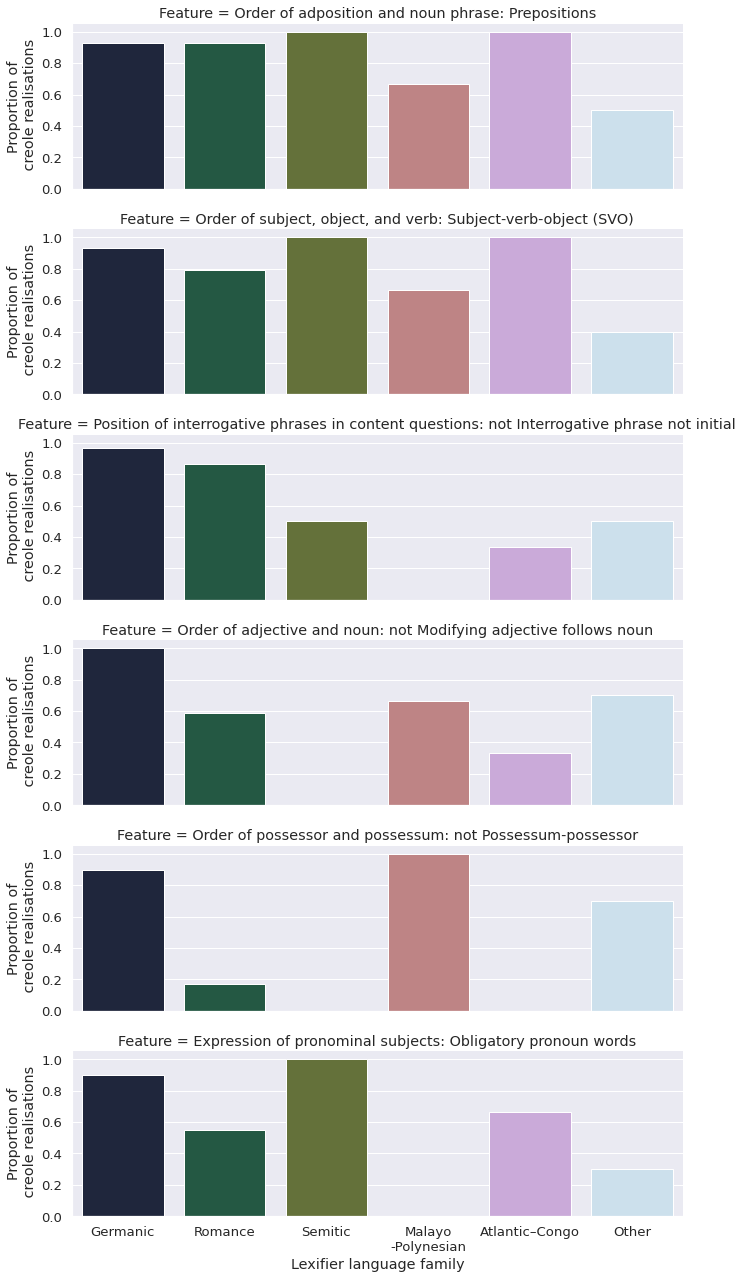

In [ ]:
sns.set(font_scale=1.2)

g = sns.FacetGrid(df_lexifier_by_fam1, row="Feature",
                  height=3, aspect=3.4)
g.map(sns.barplot, "Lexifier language family", 'Proportion of\n creole realisations', palette="cubehelix")

plt.savefig('creole_f_lexifiers_fam1.png', bbox_inches = "tight")

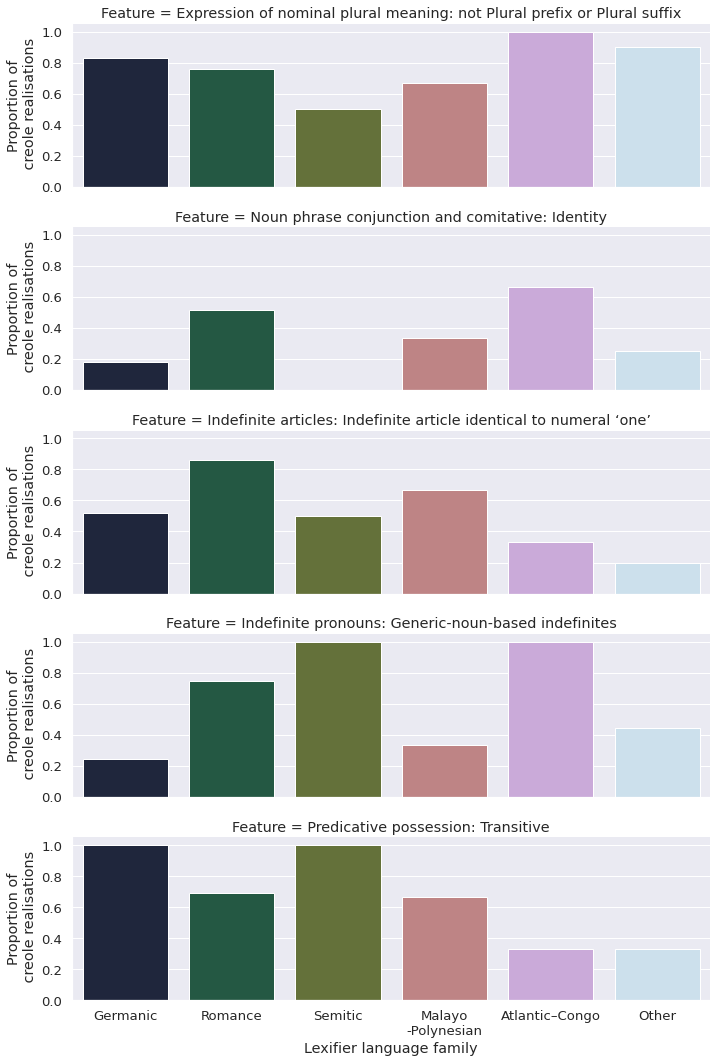

In [ ]:
sns.set(font_scale=1.2)

g = sns.FacetGrid(df_lexifier_by_fam2, row="Feature",
                  height=3, aspect=3.4)
g.map(sns.barplot, "Lexifier language family", 'Proportion of\n creole realisations', palette="cubehelix")

plt.savefig('creole_f_lexifiers_fam2.png', bbox_inches = "tight")

Proportion of native speakers

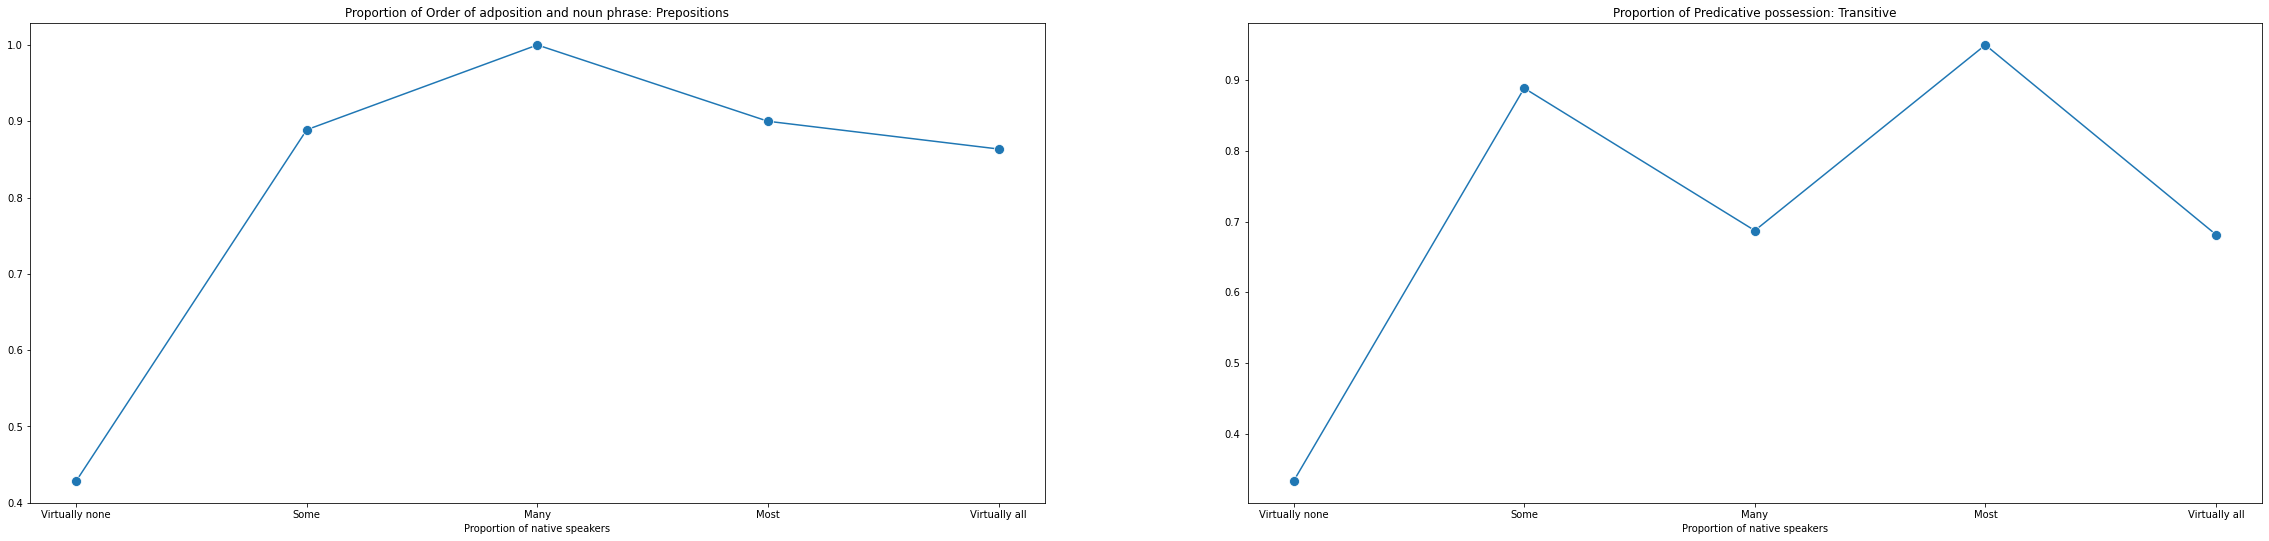

In [ ]:
i = 1
fig = plt.figure(figsize=(40, 30))
for data in all_contingency_table_for_sign_p['Proportion of native speakers']:
    plt.subplot(3, 2, i)
    proportion_column = data.columns[-1]
    data = data[[proportion_column]]
    sns.lineplot(x=data.index, y=data[proportion_column], marker="o", markersize=10)
    plt.ylabel('')
    plt.title(proportion_column)
    i += 1

Ongoing creolization of pidgins

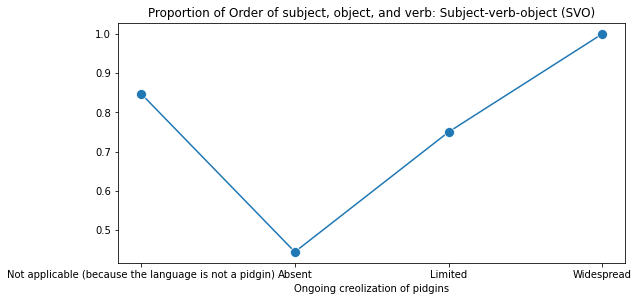

In [ ]:
i = 1
fig = plt.figure(figsize=(20, 15))
for data in all_contingency_table_for_sign_p['Ongoing creolization of pidgins']:
    plt.subplot(3, 2, i)
    proportion_column = data.columns[-1]
    data = data[[proportion_column]]
    sns.lineplot(x=data.index, y=data[proportion_column], marker="o", markersize=10)
    plt.ylabel('')
    plt.title(proportion_column)
    i += 1

Language abandonment

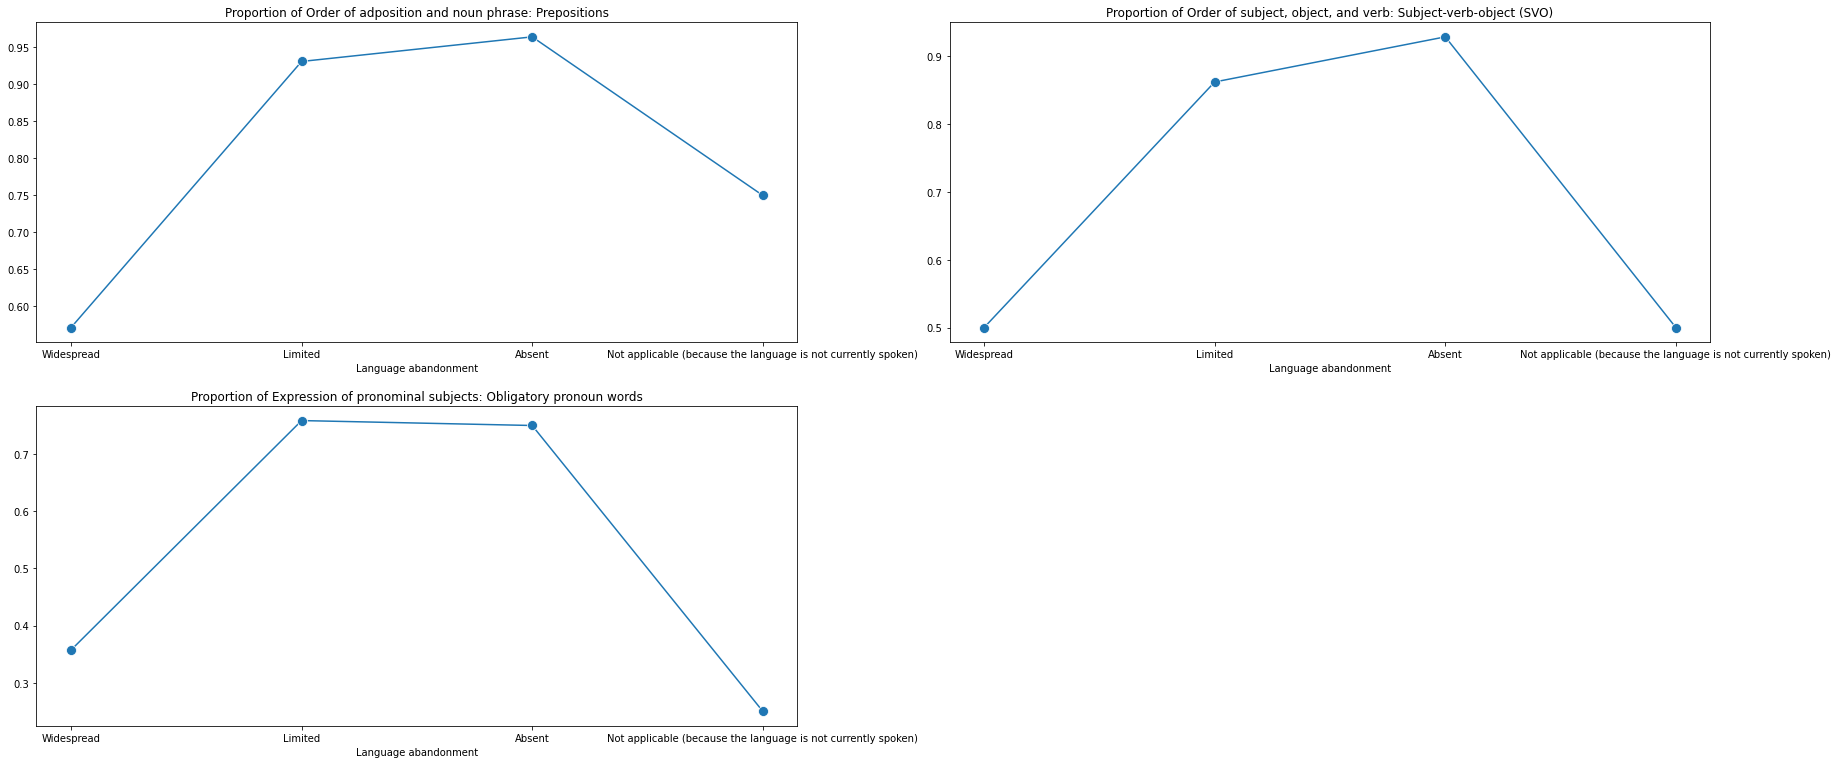

In [ ]:
i = 1
fig = plt.figure(figsize=(30, 20))
for data in all_contingency_table_for_sign_p['Language abandonment']:
    plt.subplot(3, 2, i)
    proportion_column = data.columns[-1]
    data = data[[proportion_column]]
    sns.lineplot(x=data.index, y=data[proportion_column], marker="o", markersize=10)
    plt.ylabel('')
    plt.title(proportion_column)
    i += 1

Size of speaker community


In [ ]:
proportion_column = all_contingency_table_for_sign_p['Size of speaker community'][0].columns[-1]
feature_column = all_contingency_table_for_sign_p['Size of speaker community'][0].columns[0]
all_contingency_table_for_sign_p['Size of speaker community'][0][proportion_column]
#feature_column

'Order of adposition and noun phrase: Prepositions'

In [ ]:
proportion_column2 = all_contingency_table_for_sign_p['Size of speaker community'][0].columns[-1]
feature_column2 = all_contingency_table_for_sign_p['Size of speaker community'][0].columns[0]
all_contingency_table_for_sign_p['Size of speaker community'][0][proportion_column2]
#feature_column2

Size of speaker community
Less than 100 speakers or extinct    0.500000
Less than 1,000 speakers             0.714286
Less than 10,000 speakers            0.916667
Less than 100,000 speakers           0.941176
Less than 1,000,000 speakers         1.000000
More than 1,000,000 speakers         0.937500
Name: Proportion of Order of adposition and noun phrase: Prepositions, dtype: float64

In [ ]:
df_speaker_community = pd.DataFrame()
proportion = []
size_of_sc = []
feature_name = []
arr = ['Less than\n 100 speakers\nor extinct',
 'Less than\n 1,000 speakers',
 'Less than\n 10,000 speakers',
 'Less than\n 100,000 speakers',
 'Less than\n 1,000,000 speakers',
 'More than\n 1,000,000 speakers',]


for df in all_contingency_table_for_sign_p['Size of speaker community']:
    proportion_column = df.columns[-1]
    feature_column = df.columns[0]
    proportion.extend(df[proportion_column].values)
    #size_of_sc.extend([1, 2, 3, 4, 5, 6])
    size_of_sc.extend(arr)
    #size_of_sc.extend(df.index)
    feature_name.extend([feature_column]*6)

df_speaker_community['Proportion of\n creole realisations'] = proportion
df_speaker_community['Size of speaker community'] = size_of_sc
df_speaker_community['Feature'] = feature_name

In [ ]:
df_speaker_community1 = df_speaker_community[df_speaker_community['Feature']!='Order of possessor and possessum: not Possessum-possessor']

In [ ]:
#df_speaker_community
#fig = plt.figure(figsize=(20, 10))
#sns.lineplot(data=df_speaker_community1, x="Size of speaker community", y="proportion", hue="Feature", marker="o", markersize=10, style="Feature")

In [ ]:
df_speaker_community2 = pd.read_excel('data.xlsx')

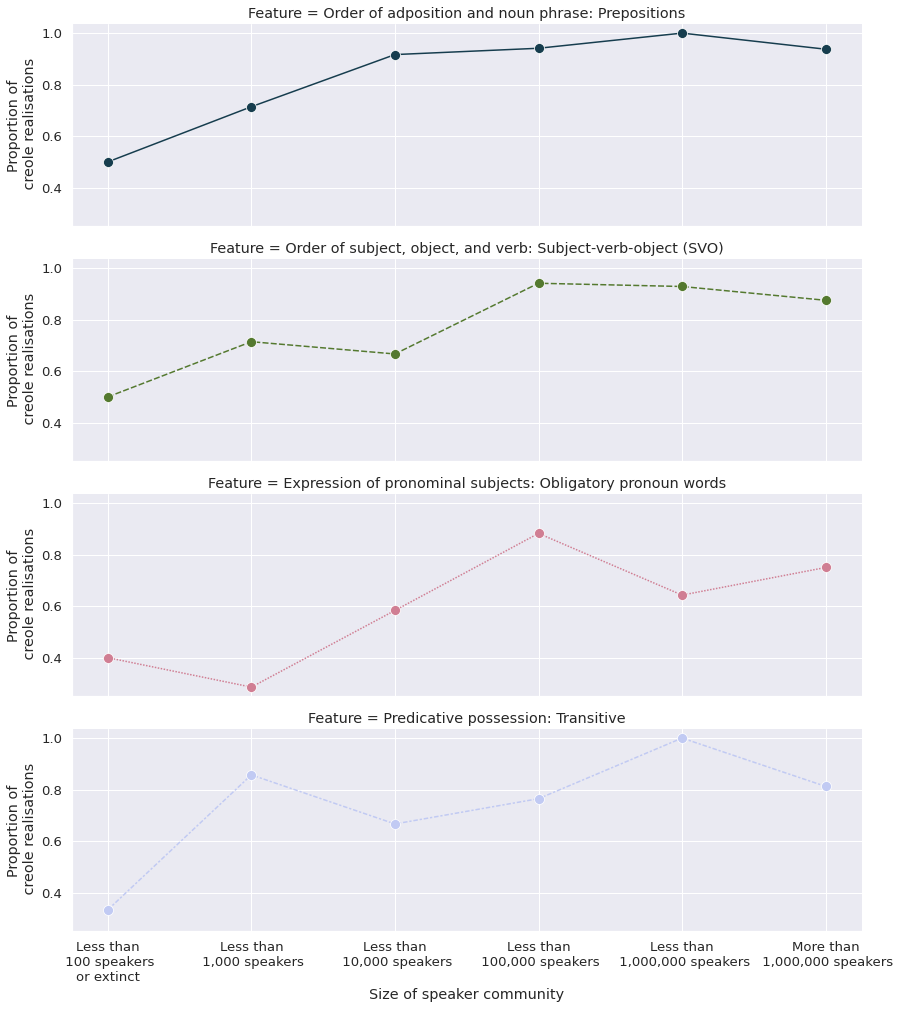

In [ ]:
sns.set(font_scale=1.2)
sns.relplot(
    data=df_speaker_community1, x="Size of speaker community", y="Proportion of\n creole realisations",
    row="Feature", hue="Feature", style="Feature",
    kind="line", height=3.5, aspect=3.5, marker="o", markersize=10,
    legend=False, palette="cubehelix"
)
plt.savefig('creole_f_size_of_sc2.png', bbox_inches = "tight")

In [ ]:
df_speaker_community2 = df_speaker_community[df_speaker_community['Feature']=='Order of possessor and possessum: not Possessum-possessor']

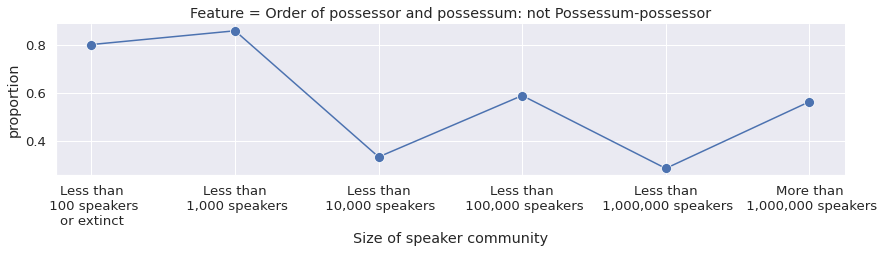

In [ ]:
sns.set(font_scale=1.2)
sns.relplot(
    data=df_speaker_community2, x="Size of speaker community", y="proportion",
    row="Feature", hue="Feature", style="Feature",
    kind="line", height=3.5, aspect=3.5, marker="o", markersize=10,
    legend=False
)
plt.savefig('creole_f_size_of_sc2.png')

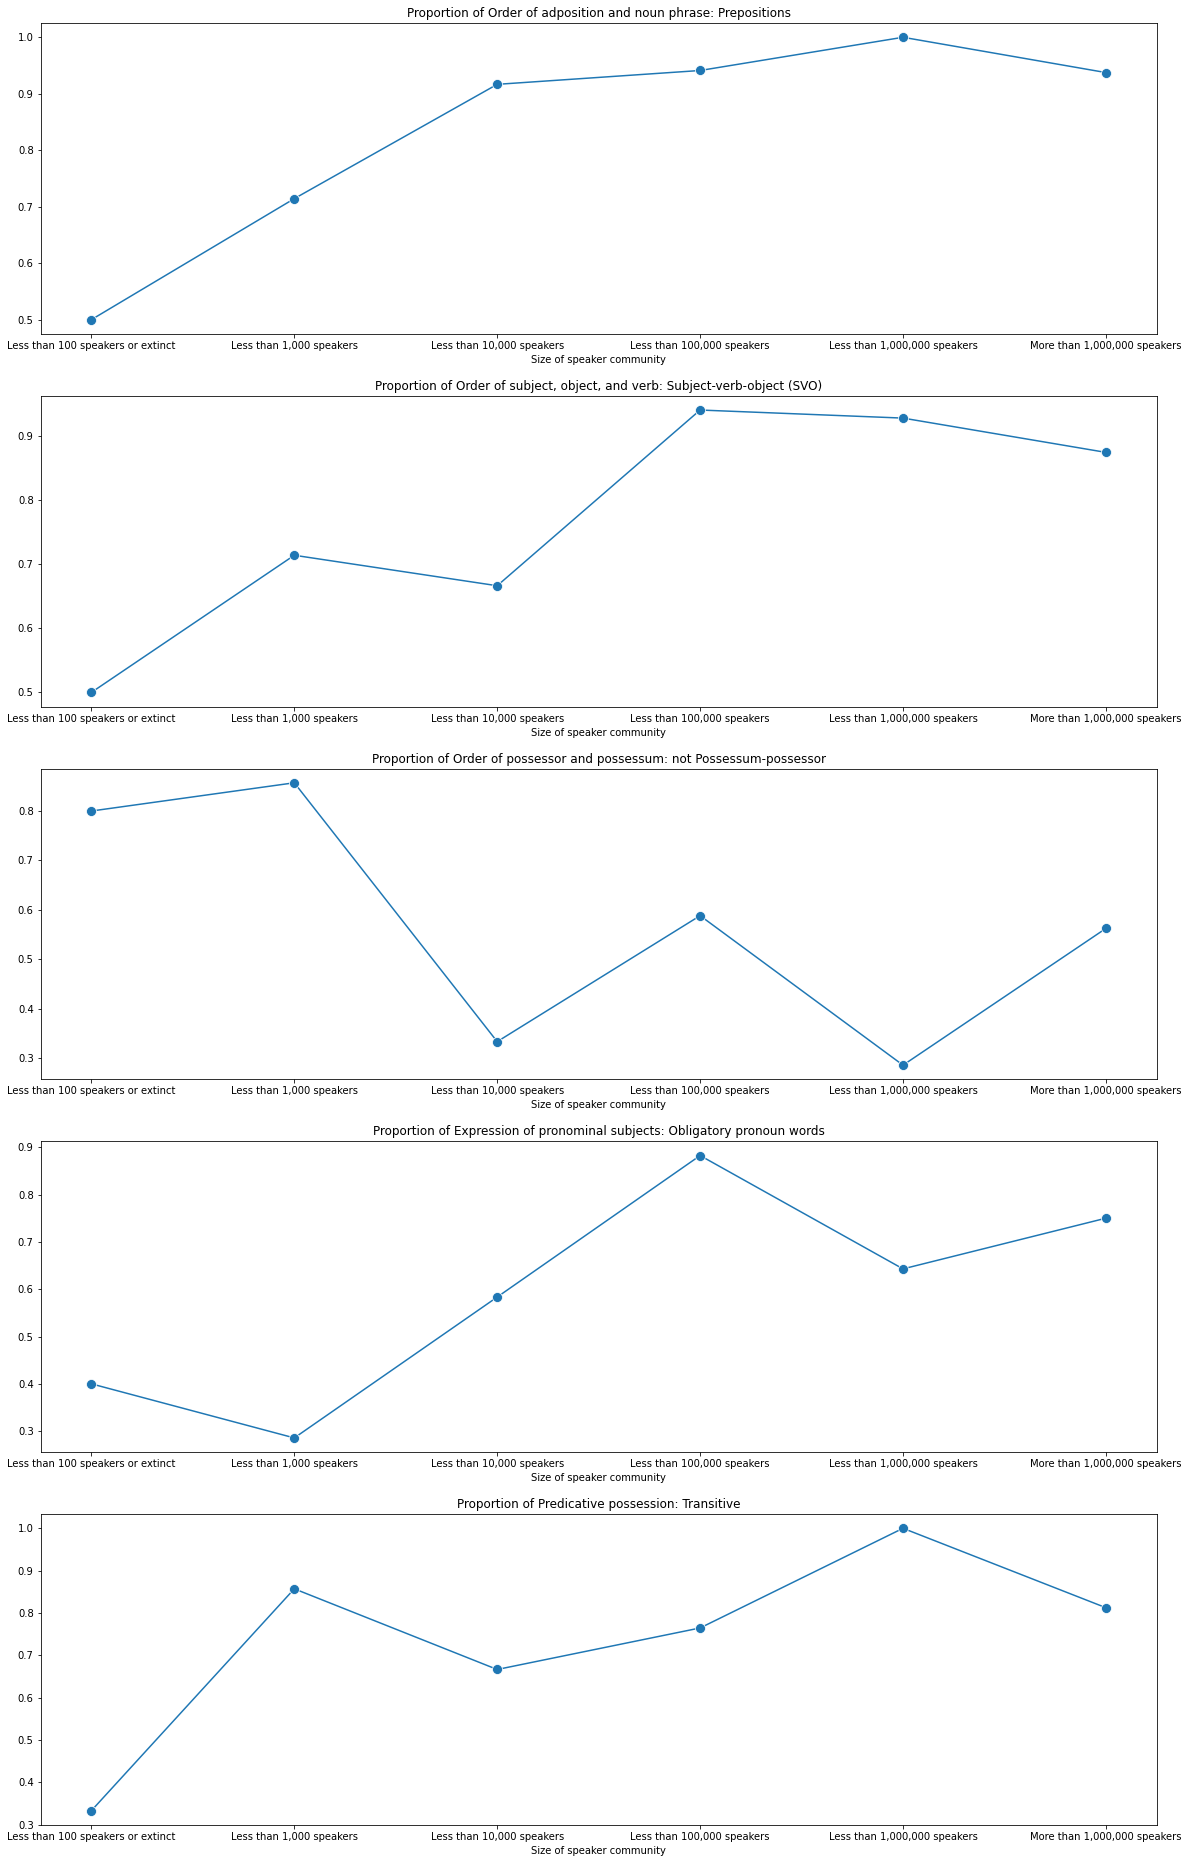

In [ ]:
i = 1
fig = plt.figure(figsize=(20, 40))
for data in all_contingency_table_for_sign_p['Size of speaker community']:
    plt.subplot(6, 1, i)
    proportion_column = data.columns[-1]
    data = data[[proportion_column]]
    sns.lineplot(x=data.index, y=data[proportion_column], marker="o", markersize=10)
    plt.ylabel('')
    plt.title(proportion_column)
    i += 1

Gender-related use

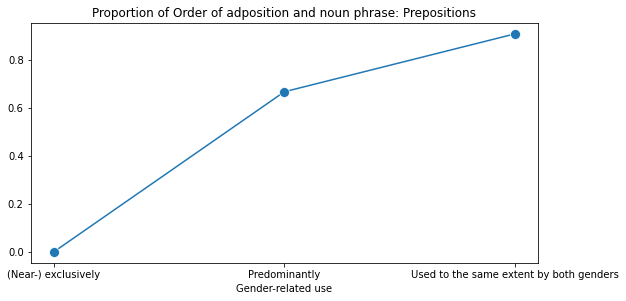

In [ ]:
i = 1
fig = plt.figure(figsize=(20, 15))
for data in all_contingency_table_for_sign_p['Gender-related use']:
    plt.subplot(3, 2, i)
    proportion_column = data.columns[-1]
    data = data[[proportion_column]]
    sns.lineplot(x=data.index, y=data[proportion_column], marker="o", markersize=10)
    plt.ylabel('')
    plt.title(proportion_column)
    i += 1

'Contact with other languages',
                     'Domains of use', 'Geographic variation', 'Urban/rural variation', 'Social variation']

Contact with other languages

In [ ]:
all_contingency_table_for_sign_p['Contact with other languages'][0]

,Order of adposition and noun phrase: Prepositions,not Order of adposition and noun phrase: Prepositions,Proportion of Order of adposition and noun phrase: Prepositions
Contact with other languages,,,
The main lexifier language,29,1,0.966667
A major world language that is not the main lexifier,15,5,0.750000
A neighbouring language that is neither the main lexifier nor a major world language,3,3,0.500000
Several different kinds of languages are equally important in terms of contact influence,18,0,1.000000


In [ ]:
df_contact_w_ol = pd.DataFrame()
proportion = []
size_of_sc = []
feature_name = []
arr = ['The main\n lexifier language',
 'A major world\n language that is not\n the main lexifier',
 'A neighbouring\n language that is neither\n the main lexifier nor\n a major world language',
 'Several different\n kinds of languages\n are equally important\n in terms of contact influence',
]


for df in all_contingency_table_for_sign_p['Contact with other languages']:
    proportion_column = df.columns[-1]
    feature_column = df.columns[0]
    proportion.extend(df[proportion_column].values)
    size_of_sc.extend(arr)
    #size_of_sc.extend(df.index)
    feature_name.extend([feature_column]*4)

df_contact_w_ol['Proportion of\n creole realisations'] = proportion
df_contact_w_ol['Contact with other languages'] = size_of_sc
df_contact_w_ol['Feature'] = feature_name

In [ ]:
df_contact_w_ol

,Proportion of\n creole realisations,Contact with other languages,Feature
0,0.966667,The main\n lexifier language,Order of adposition and noun phrase: Prepositions
1,0.750000,A major world\n language that is not\n the mai...,Order of adposition and noun phrase: Prepositions
2,0.500000,A neighbouring\n language that is neither\n th...,Order of adposition and noun phrase: Prepositions
3,1.000000,Several different\n kinds of languages\n are e...,Order of adposition and noun phrase: Prepositions
4,0.900000,The main\n lexifier language,"Order of subject, object, and verb: Subject-ve..."
5,0.750000,A major world\n language that is not\n the mai...,"Order of subject, object, and verb: Subject-ve..."
6,0.333333,A neighbouring\n language that is neither\n th...,"Order of subject, object, and verb: Subject-ve..."
7,0.944444,Several different\n kinds of languages\n are e...,"Order of subject, object, and verb: Subject-ve..."
8,0.833333,The main\n lexifier language,Expression of pronominal subjects: Obligatory ...
9,0.500000,A major world\n language that is not\n the mai...,Expression of pronominal subjects: Obligatory ...


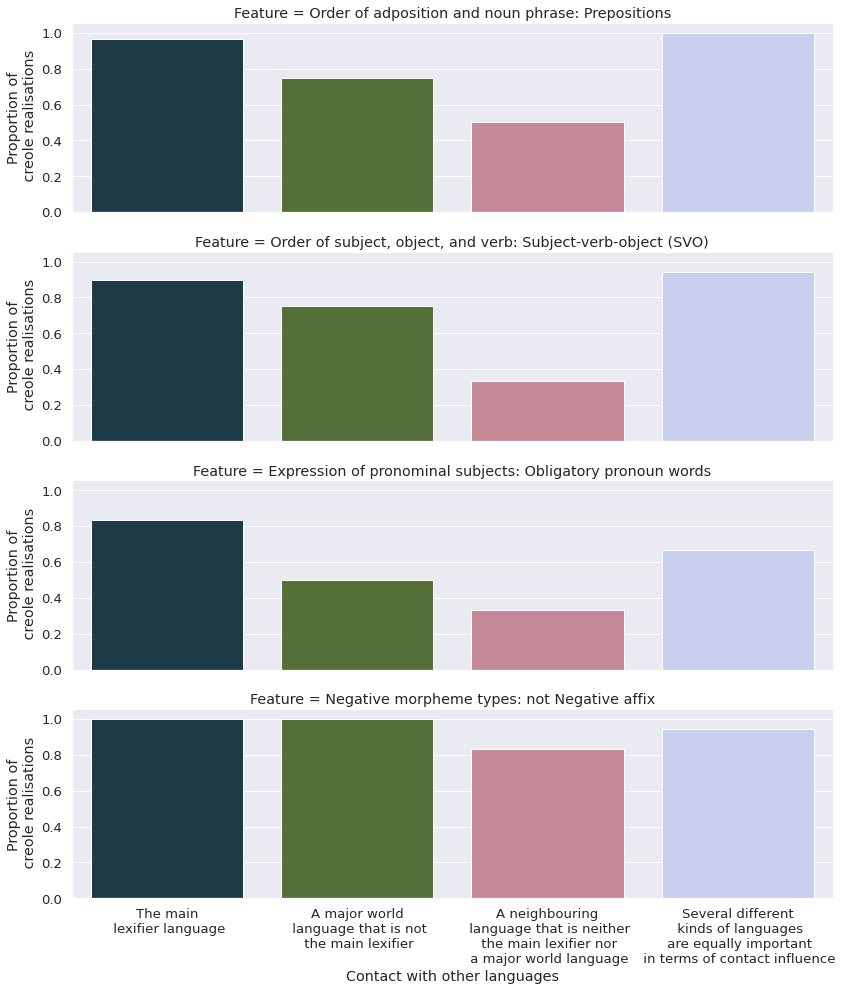

In [ ]:
sns.set(font_scale=1.2)

g = sns.FacetGrid(df_contact_w_ol, row="Feature",
                  height=3.5, aspect=3.4)
g.map(sns.barplot, "Contact with other languages", 'Proportion of\n creole realisations', palette="cubehelix")

plt.savefig('creole_f_contacts.png', bbox_inches = "tight")

Domains of use

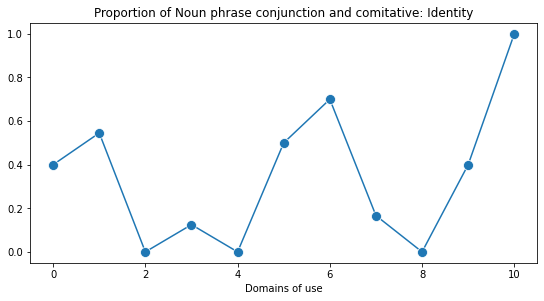

In [ ]:
i = 1
fig = plt.figure(figsize=(20, 15))
for data in all_contingency_table_for_sign_p['Domains of use']:
    plt.subplot(3, 2, i)
    proportion_column = data.columns[-1]
    data = data[[proportion_column]]
    sns.lineplot(x=data.index, y=data[proportion_column], marker="o", markersize=10)
    plt.ylabel('')
    plt.title(proportion_column)
    i += 1

Urban/rural variation

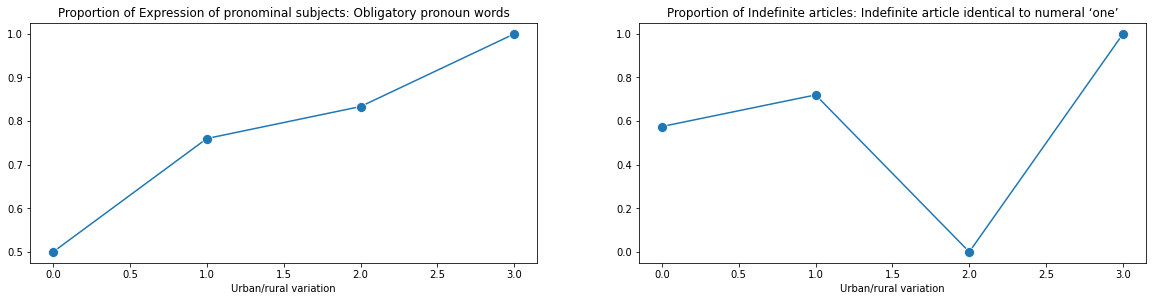

In [ ]:
i = 1
fig = plt.figure(figsize=(20, 15))
for data in all_contingency_table_for_sign_p['Urban/rural variation']:
    plt.subplot(3, 2, i)
    proportion_column = data.columns[-1]
    data = data[[proportion_column]]
    sns.lineplot(x=data.index, y=data[proportion_column], marker="o", markersize=10)
    plt.ylabel('')
    plt.title(proportion_column)
    i += 1

#Проверить зависимость между лексификатором и размером языкового сообщества


In [ ]:
data = all_languages_Cysouw_creole_features_table[['Lexifier language', 'Size of speaker community']]
b = data.groupby(['Lexifier language', 'Size of speaker community']).size()
#b.columns = ['Lexifier language', 'Size of speaker community', 'Amount']
pd.DataFrame(b)
#.reset_index().groupby('col2')[[0]].max()

0
Lexifier language Size of speaker community            
Arabic            Less than 1,000,000 speakers        2
Bantu             More than 1,000,000 speakers        3
Dutch             Less than 100 speakers or extinct   2
                  More than 1,000,000 speakers        1
English           Less than 1,000 speakers            2
                  Less than 1,000,000 speakers        4
                  Less than 10,000 speakers           1
                  Less than 100,000 speakers         10
                  More than 1,000,000 speakers        9
French            Less than 1,000,000 speakers        3
                  Less than 10,000 speakers           2
                  Less than 100,000 speakers          2
                  More than 1,000,000 speakers        2
Malay             Less than 1,000,000 speakers        1
                  Less than 10,000 speakers           1
                  Less than 100,000 speakers          1
Other             Less than 1,000 speakers            2
                  Less than 10,000 speakers           2
                  Less than 100 speakers or extinct   5
                  More than 1,000,000 speakers        1
Portuguese        Less than 1,000 speakers            3
                  Less than 1,000,000 speakers        2
                  Less than 10,000 speakers           2
                  Less than 100 speakers or extinct   3
                  Less than 100,000 speakers          4
Spanish           Less than 1,000,000 speakers        2
                  Less than 10,000 speakers           4

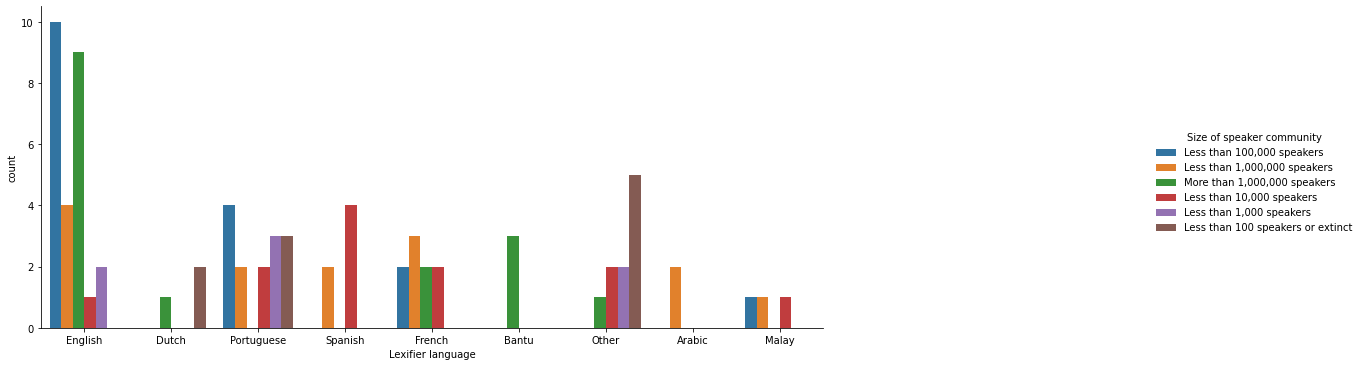

In [ ]:
#sns.catplot(x="Lexifier language", hue='Size of speaker community', kind="count", data=data, width=100)

g = sns.catplot(x="Lexifier language", hue='Size of speaker community', kind="count", data=data)
g.fig.set_figwidth(20)
g.fig.set_figheight(5)

In [ ]:
data.apply(lambda x : pd.factorize(x)[0]).corr(method='spearman', min_periods=1)

,Lexifier language,Size of speaker community
Lexifier language,1.000000,0.292664
Size of speaker community,0.292664,1.000000
